In [1]:
# Import the libraries
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
# Global variables
MAZE_FILE_NAME = "../Maze_2.png"
ROBOT_FILE_NAME = "../Robot_2.png"
IMAGE_LADYBUG_FILE_NAME = "../Ladybug_small.png"
MAP_FILE_NAME = "../MapBuilt.txt"

# Functions


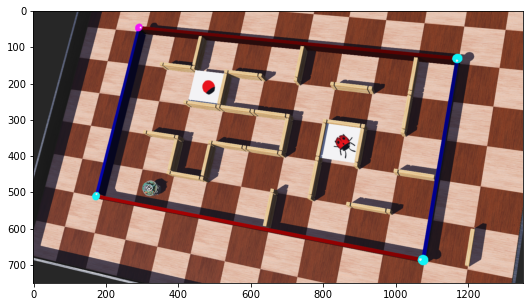

In [2]:
# Task 3.1 Read in an image and display it in RGB mode
if __name__ == "__main__":
    maze = cv2.imread(MAZE_FILE_NAME)
    mazeRGB = cv2.cvtColor(maze, cv2.COLOR_BGR2RGB)
    plt.figure(figsize = (9,5))
    plt.imshow(mazeRGB)
    

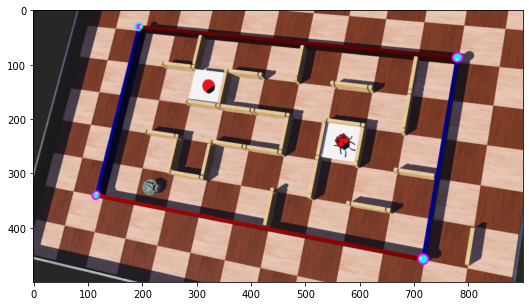

In [3]:
# Task 3.2 Find four cornerstones of maze
if __name__ == "__main__":
    mazeCorners = mazeRGB.copy()
    # Convert to HSV to track colours easier
    mazeHSV = cv2.cvtColor(mazeCorners, cv2.COLOR_RGB2HSV)
    
    # Create cyan mask [90, 235, 245], [90, 240, 245]
    lowerCyan = np.array([90, 50, 200])
    upperCyan = np.array([90, 255, 255])
    maskCyan = cv2.inRange(mazeHSV, lowerCyan, upperCyan)
    
    # Create pink mask [150, 234, 245]
    lowerPink = np.array([150, 50, 200])
    upperPink = np.array([150, 255, 255])
    maskPink = cv2.inRange(mazeHSV, lowerPink, upperPink)
    
    # Find contours
    _, contoursCyan, _ = cv2.findContours(maskCyan, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    _, contoursPink, _ = cv2.findContours(maskPink, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Draw pink contours around cyan cornerstones
    for contour in contoursCyan:
        epsilon = 0.02 * cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, epsilon, True)
        if len(approx) > 5:
            cv2.drawContours(mazeCorners, [contour], -1, (255, 0, 255), 3)
    
    # Draw cyan contours around pink cornerstones
    for contour in contoursPink:
        epsilon = 0.02 * cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, epsilon, True)
        if len(approx) > 5:
            cv2.drawContours(mazeCorners, [contour], -1, (0, 255, 255), 3)
    
    # Resize image
    dim = (900, 500)
    resized = cv2.resize(mazeCorners, dim, interpolation = cv2.INTER_AREA)
    
    # Plot maze with cornerstones outlined
    plt.figure(figsize = (9,5))
    plt.imshow(resized)

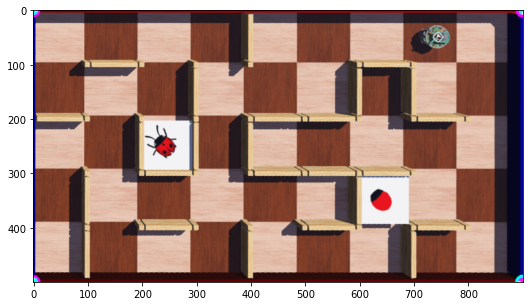

In [4]:
# Task 3.3 Perspective transform maze to rectangle image
if __name__ == "__main__":
    mazeTransformed = mazeCorners.copy()
    A = B = C = D = [0,0]
    # Get position of centre of pink cornerstone
    flipped = False
    for contour in contoursPink:
        M = cv2.moments(contour)
        if M['m00'] != 0:
            cx = int(M['m10']/M['m00'])
            cy = int(M['m01']/M['m00'])
            # Check if pink cornerstone is in region A or D
            if cy < 375:
                # Region A
                flipped = True
                A = [cx,cy]
            else:
                # Region D
                D = [cx,cy]
    
    # Get position of centre of cyan cornerstones
    for contour in contoursCyan:
        M = cv2.moments(contour)
        if M['m00'] != 0:
            cx = int(M['m10']/M['m00'])
            cy = int(M['m01']/M['m00'])
            # Check which region the cornerstone is in
            if cx <= 337.5:
                if cy <= 375:
                    A = [cx,cy]
                else:
                    C = [cx,cy]
            else:
                if cy <= 375:
                    B = [cx,cy]
                else:
                    D = [cx,cy]
    
    # Find Homographic Matrix
    if flipped:
        pts1 = np.float32([D,C,B,A])
    else:
        pts1 = np.float32([A,B,C,D])
    pts2 = np.float32([[0,0],[900,0],[0,500],[900,500]])
    H = cv2.getPerspectiveTransform(pts1, pts2)
    
    # Transform image and plot maze with each cornerstone at each corner
    dst = cv2.warpPerspective(mazeTransformed, H, (900,500))
    plt.figure(figsize = (9,5))
    plt.imshow(dst)

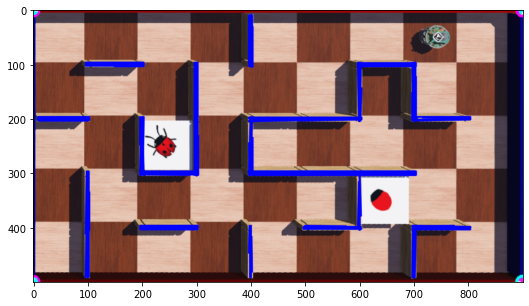

In [5]:
# Task 3.4 Detect all internal walls
if __name__ == "__main__":
    mazeWalls = dst.copy() # Create copy of transformed image
    dstHSV = cv2.cvtColor(dst, cv2.COLOR_RGB2HSV)
    # [18 108 230] [18 95 226] [19 99 229]
    lowerWall = np.array([17, 80, 220])
    upperWall = np.array([19, 120, 240])
    maskWall = cv2.inRange(dstHSV, lowerWall, upperWall)
    
    kernel = np.ones((3,3),np.uint8)
    maskWall2 = cv2.morphologyEx(maskWall, cv2.MORPH_CLOSE, kernel, iterations=3)
    
    # Apply HoughLines to form the walls
    walls = cv2.HoughLinesP(maskWall2, rho=1, theta=np.pi/180.0, threshold=50, minLineLength=50, maxLineGap=10)
    if walls is not None:
        for i in range(0, len(walls)):
            l = walls[i][0]
            cv2.line(mazeWalls, (l[0], l[1]), (l[2], l[3]), (0,0,255), 2, cv2.LINE_AA)
    
    blue = np.array([0,0,255])
    maskBlue = cv2.inRange(mazeWalls, blue, blue)
    
    vWall = [[0 for j in range(8)] for i in range (5)]
    hWall = [[0 for j in range(9)] for i in range(4)]
    # Create vertical wall array
    for i in range(5):
        for j in range(8):
            border = maskBlue[i*100:i*100+100,j*100+90:j*100+110] #[y,x]
            if cv2.countNonZero(border) > 300:
                vWall[i][j] = 1
    # Create horizontal wall array
    for i in range(4):
        for j in range(9):
            border = maskBlue[i*100+90:i*100+110,j*100:j*100+100]
            if cv2.countNonZero(border) > 300:
                hWall[i][j] = 1
    plt.figure(figsize = (9,5))
    plt.imshow(mazeWalls)

0
0
0
0
0
0
0
136
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


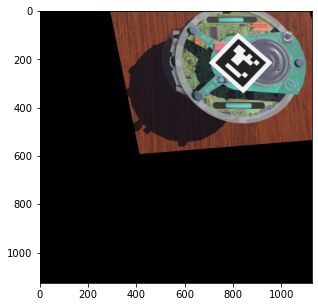

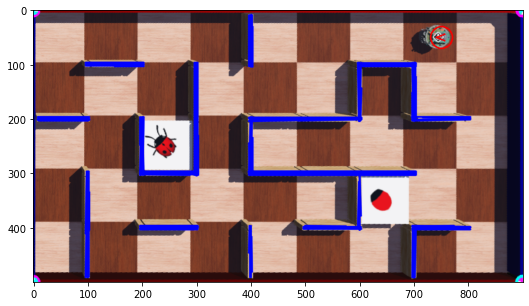

In [6]:
# Task 3.5 Detect location and heading of robot
if __name__ == "__main__":
    mazeRobot = mazeWalls.copy()
    # Find location of robot
    robot = cv2.imread(ROBOT_FILE_NAME)
    robotRGB = cv2.cvtColor(robot,cv2.COLOR_BGR2RGB)
    robotHSV = cv2.cvtColor(robot,cv2.COLOR_BGR2HSV)

    lowerGreen = np.array([70, 110, 60])
    upperGreen = np.array([100, 200, 200])
    maskGreen = cv2.inRange(robotHSV, lowerGreen, upperGreen)
    
    highest = 0
    for i in range(5):
        for j in range(9):
            cell = mazeRobot[i*100:(i*100)+100,j*100:(j*100)+100]
            maskGreen = cv2.inRange(cell, lowerGreen, upperGreen)
            # Check if robot is in current cell
            if cv2.countNonZero(maskGreen) > highest:
                cx = j*100+50
                cy = i*100+50
                robotx = j
                roboty = i
                highest = cv2.countNonZero(maskGreen)
    
    # Draw circle
    cv2.circle(mazeRobot,(cx,cy),20,(250,0,0),2)

    # Find heading of robot
    heading = " ^ "
    tRobot = cv2.warpPerspective(robotRGB, H, (1125,1125))
    # Load predefined dictionary - code from Lecture 8 Slides, Slide 80
    dictionary = cv2.aruco.Dictionary_get(cv2.aruco.DICT_6X6_250)
    parameters = cv2.aruco.DetectorParameters_create()
    # Detect markers in image
    corners, ids, _ = cv2.aruco.detectMarkers(tRobot, dictionary, parameters=parameters)
    # If no corners found, pad image and keep trying until found
    if not corners:
        # Add padding to robot before transforming
        robotB = cv2.copyMakeBorder(robotRGB, 300, 0, 0, 0, cv2.BORDER_CONSTANT, (0,0,0))
        tRobot = cv2.warpPerspective(robotB, H, (1125,1125))
        corners, ids, _ = cv2.aruco.detectMarkers(tRobot, dictionary, parameters=parameters)
    if not corners:
        robotB = cv2.copyMakeBorder(robotRGB, 0, 300, 0, 0, cv2.BORDER_CONSTANT, (0,0,0))
        tRobot = cv2.warpPerspective(robotB, H, (1125,1125))
        corners, ids, _ = cv2.aruco.detectMarkers(tRobot, dictionary, parameters=parameters)
    if not corners:
        robotB = cv2.copyMakeBorder(robotRGB, 0, 0, 300, 0, cv2.BORDER_CONSTANT, (0,0,0))
        tRobot = cv2.warpPerspective(robotB, H, (1125,1125))
        corners, ids, _ = cv2.aruco.detectMarkers(tRobot, dictionary, parameters=parameters)
    if not corners:
        robotB = cv2.copyMakeBorder(robotRGB, 0, 0, 0, 300, cv2.BORDER_CONSTANT, (0,0,0))
        tRobot = cv2.warpPerspective(robotB, H, (1125,1125))
        corners, ids, _ = cv2.aruco.detectMarkers(tRobot, dictionary, parameters=parameters)
    corners = corners[0][0]
    x = 0
    y = 1
    # Check heading based on top-left corner
    if corners[0][y] < corners[1][y] and corners[0][y] < corners[2][y] and corners[0][y] < corners[3][y]:
        # heading is "^"
        cv2.line(mazeRobot,(cx,cy-10),(cx+6,cy+6),(250,0,0),2)
        cv2.line(mazeRobot,(cx,cy-10),(cx-6,cy+6),(250,0,0),2)
    elif corners[0][x] > corners[1][x] and corners[0][x] > corners[2][x] and corners[0][x] > corners[3][x]:
        heading = " > "
        cv2.line(mazeRobot,(cx+10,cy),(cx-6,cy+6),(250,0,0),2)
        cv2.line(mazeRobot,(cx+10,cy),(cx-6,cy-6),(250,0,0),2)
    elif corners[0][y] > corners[1][y] and corners[0][y] > corners[2][y] and corners[0][y] > corners[3][y]:
        heading = " v "
        cv2.line(mazeRobot,(cx,cy+8),(cx+6,cy-8),(250,0,0),2)
        cv2.line(mazeRobot,(cx,cy+8),(cx-6,cy-8),(250,0,0),2)
    else:
        heading = " < "
        cv2.line(mazeRobot,(cx-10,cy),(cx+6,cy+6),(250,0,0),2)
        cv2.line(mazeRobot,(cx-10,cy),(cx+6,cy-6),(250,0,0),2)
    
    plt.figure(figsize = (9,5))
    plt.imshow(mazeRobot)

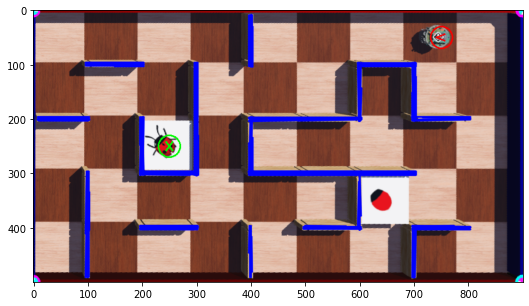

In [7]:
# Task 3.6 Detect position of true target
if __name__ == "__main__":
    mazeTarget = mazeRobot.copy()
    
    # keypoints and descriptors with ORB - code from Week 8 Slides
    ladybug = cv2.imread(IMAGE_LADYBUG_FILE_NAME)
    ladybugGray = cv2.cvtColor(ladybug, cv2.COLOR_BGR2GRAY)
    a = cv2.xfeatures2d.SIFT_create()
    kp3, des3 = a.detectAndCompute(ladybugGray, None)

    for i in range(5):
        for j in range(9):
            cell = mazeWalls[i*100:(i*100)+100,j*100:(j*100)+100]
            cellGray = cv2.cvtColor(cell, cv2.COLOR_RGB2GRAY)
            kp4, des4 = a.detectAndCompute(cellGray, None)
            bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck = True)
            matches2 = bf.match(des4,des3)
#             print(i,',',j,':',len(matches2))
            if len(matches2) > 28 and not (i == roboty and j == robotx):
                cx = j*100+50
                cy = i*100+50
                cv2.circle(mazeTarget,(cx,cy),20,(0,250,0),2)
                cv2.line(mazeTarget,(cx+6,cy+8),(cx-6,cy-8),(0,250,0),2)
                cv2.line(mazeTarget,(cx-6,cy+8),(cx+6,cy-8),(0,250,0),2)
                # save coordinates of target
                targetx = j
                targety = i
    
    plt.figure(figsize = (9,5))
    plt.imshow(mazeTarget)

In [8]:
# Task 3.7 Generate map and write to "MapBuilt.txt"
if __name__ == "__main__":
    with open(MAP_FILE_NAME, 'w') as file:
        # Generate map as string
        border = " --- --- --- --- --- --- --- --- --- \n"
        file.write(border)
        for i in range(5):
            file.write("|")
            for j in range(8):
                # print vertical walls
                if j == robotx and i == roboty:
                    file.write(heading)
                elif j == targetx and i == targety:
                    file.write(" x ")
                else:
                    file.write("   ")
                if vWall[i][j]:
                    file.write("|")
                else:
                    file.write(" ")
            if j+1 == robotx and i == roboty:
                file.write(heading)
            elif j+1 == targetx and i == targety:
                file.write(" x ")
            else:
                file.write("   ")
            file.write("|\n")
            # print horizontal walls
            if i == 4:
                break
            for k in range(9):
                if hWall[i][k]:
                    file.write(" ---")
                else:
                    file.write("    ")
            file.write(" \n")
        file.write(border)
        file.close()